In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import hvplot.pandas
#import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
#loading the file
lmb_data = pd.read_csv('../Downloads/lmb-data.csv')

In [4]:
lmb_data.head()

,state,district,incmbncy,demvote,repvote,year,congress,occupanc,name,eq_Dwhip,...,pres_rep_pct,n,lagged,_merge,democrat,lagdemocrat,score,lagscore,id,id2
0,1,1,-1.0,127802.0,103294.0,1948,81,0.0,"RIBICOFF,",0.752336,...,NaN,1,14.760000,3,1,0,64.339996,14.760000,3,1
1,1,1,-1.0,127802.0,103294.0,1948,81,0.0,"RIBICOFF,",0.752336,...,NaN,2,9.520001,3,1,0,60.279999,9.520001,4,1
2,1,1,1.0,134258.0,96251.0,1950,82,0.0,"RIBICOFF,",0.770270,...,NaN,1,64.339996,3,1,1,57.060001,64.339996,5,1
3,1,1,1.0,134258.0,96251.0,1950,82,0.0,"RIBICOFF,",0.770270,...,NaN,2,60.279999,3,1,1,73.830002,60.279999,6,1
4,1,1,1.0,148935.0,112526.0,1954,84,0.0,DODD,0.730769,...,NaN,1,56.220001,3,1,1,42.959999,56.220001,7,1


In [5]:
lmb_data.columns

Index(['state', 'district', 'incmbncy', 'demvote', 'repvote', 'year',
       'congress', 'occupanc', 'name', 'eq_Dwhip',
       ...
       'pres_rep_pct', 'n', 'lagged', '_merge', 'democrat', 'lagdemocrat',
       'score', 'lagscore', 'id', 'id2'],
      dtype='object', length=178)

In [6]:
def lm_robust(formula, data):
    regression = sm.OLS.from_formula(formula, data = data)
    regression = regression.fit(cov_type="cluster",cov_kwds={"groups":data['id']})
    return regression

In [7]:
from itertools import combinations 
import plotnine as p

### 1(a) No bandwidth

In [8]:
lmb_data['demvoteshare_c'] = lmb_data['demvoteshare'] - 0.5
# drop missing values
lmb_data = lmb_data[~pd.isnull(lmb_data.demvoteshare_c)]
lmb_data['demvoteshare_sq'] = lmb_data['demvoteshare_c']**2

#aggregating the data
#lmb_data = lmb_data[lmb_data.demvoteshare.between(.45, .55)]
categories = lmb_data.lagdemvoteshare
lmb_data['lagdemvoteshare_100'] = pd.cut(lmb_data.lagdemvoteshare, 100)

agg_lmb_data = lmb_data.groupby('lagdemvoteshare_100')['score'].mean().reset_index()
lmb_data['gg_group'] = [1 if x>.5 else 0 for x in lmb_data.lagdemvoteshare]
agg_lmb_data['lagdemvoteshare'] = np.arange(0.01, 1.01, .01)

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\stats\smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 15 rows containing missing values.


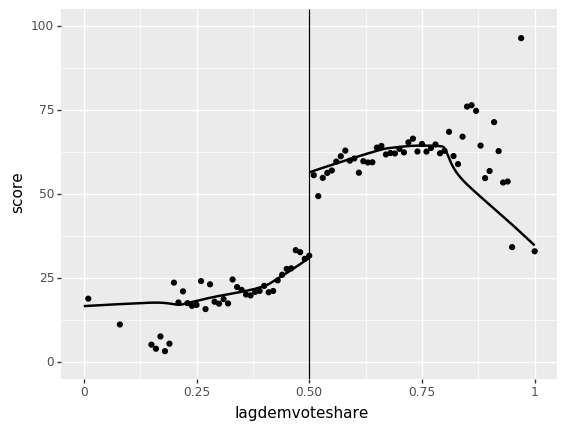

<ggplot: (-9223371908743887892)>

In [80]:
p.ggplot(lmb_data, p.aes('lagdemvoteshare', 'score')) +    p.geom_point(p.aes(x = 'lagdemvoteshare', y = 'score'), data = agg_lmb_data) +    p.stat_smooth(p.aes('lagdemvoteshare', 'score', group = 'gg_group'), 
                  data=lmb_data, method = "lowess") +\
    p.xlim(0,1) + p.ylim(0,100) +\
    p.geom_vline(xintercept = 0.5)

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\scales\scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 13 rows containing missing values.


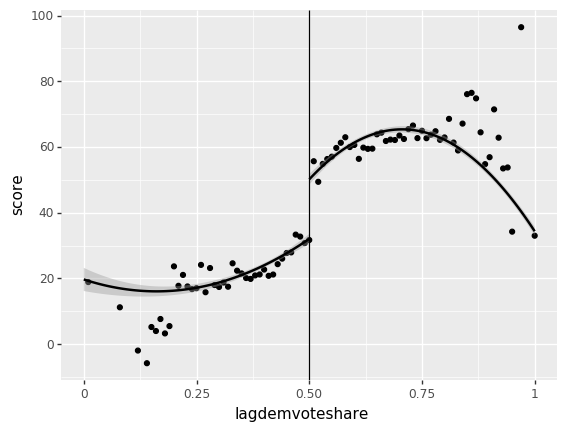

In [11]:
# quadratic plot
plot = (p.ggplot(lmb_data, p.aes('lagdemvoteshare', 'score')) +    p.geom_point(p.aes(x = 'lagdemvoteshare', y = 'score'), data = agg_lmb_data) +    p.stat_smooth(p.aes('lagdemvoteshare', 'score', group = 'gg_group'), 
                  data=lmb_data, method = "lm", 
              formula = 'y ~ x + I(x**2)') +\
    p.xlim(0,1) + p.ylim(0,100) +\
    p.geom_vline(xintercept = 0.5)
       )

plot += p.scale_y_continuous(breaks=range(0, int(lmb_data['score'].max()) + 20, 20))

print(plot)

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 15 rows containing missing values.


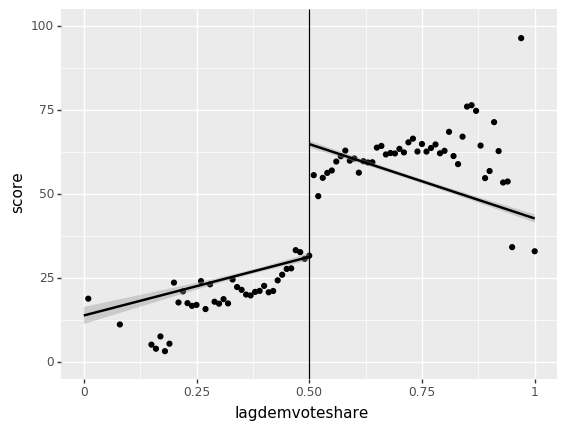

<ggplot: (-9223371908751057308)>

In [10]:
# Linear plot
p.ggplot(lmb_data, p.aes('lagdemvoteshare', 'score')) +    p.geom_point(p.aes(x = 'lagdemvoteshare', y = 'score'), data = agg_lmb_data) +    p.stat_smooth(p.aes('lagdemvoteshare', 'score', group = 'gg_group'), 
                  data=lmb_data, method = "lm")+\
    p.xlim(0,1) + p.ylim(0,100) +\
    p.geom_vline(xintercept = 0.5)

### 1(b) A bandwidth of +/- 0.05 around the threshold

In [12]:
lmb_data2 = lmb_data.copy()

In [13]:
lmb_data2['demvoteshare_c'] = lmb_data2['demvoteshare'] - 0.5
# drop missing values
lmb_data2 = lmb_data2[~pd.isnull(lmb_data2.demvoteshare_c)]
lmb_data2['demvoteshare_sq'] = lmb_data2['demvoteshare_c']**2

#aggregating the data
lmb_data2 = lmb_data2[lmb_data2.demvoteshare.between(.45, .55)]
categories2 = lmb_data2.lagdemvoteshare
lmb_data2['lagdemvoteshare_100'] = pd.cut(lmb_data2.lagdemvoteshare, 100)

agg_lmb_data2 = lmb_data2.groupby('lagdemvoteshare_100')['score'].mean().reset_index()
lmb_data2['gg_group'] = [1 if x>.5 else 0 for x in lmb_data2.lagdemvoteshare]
agg_lmb_data2['lagdemvoteshare'] = np.arange(0.01, 1.01, .01)

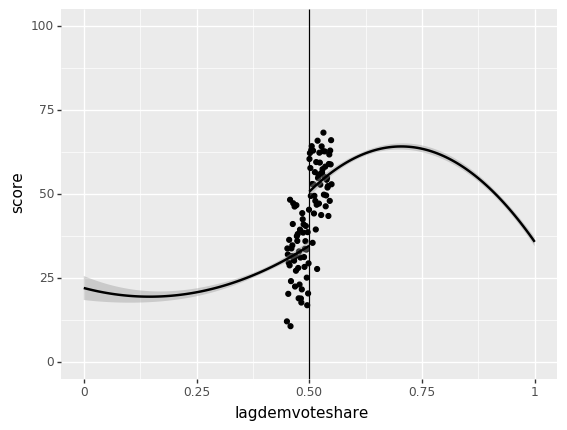

In [91]:
lmb_data2 = lmb_data[abs(lmb_data['lagdemvoteshare'] - 0.5) <= 0.05]

# 2. Aggregate the data
bins = pd.cut(lmb_data2['lagdemvoteshare'], 100)
agg_lmb_data2 = lmb_data2.groupby(bins)['score'].mean().reset_index(name='score')
agg_lmb_data2['lagdemvoteshare'] = [interval.mid for interval in bins.cat.categories]

# 3. Create a new grouping variable
lmb_data['gg_group'] = np.where(lmb_data['lagdemvoteshare'] > 0.5, 1, 0)

# 4. Plotting
plot2 = (p.ggplot(lmb_data, p.aes(x='lagdemvoteshare', y='score')) +
        p.geom_point(p.aes(x='lagdemvoteshare', y='score'), data=agg_lmb_data2) +
        p.stat_smooth(p.aes('lagdemvoteshare', 'score', group='gg_group'), method='lm', 
                      formula='y ~ x + I(x**2)') +
        p.xlim(0, 1) + p.ylim(0, 100) +
        p.geom_vline(xintercept=0.5))

print(plot2)

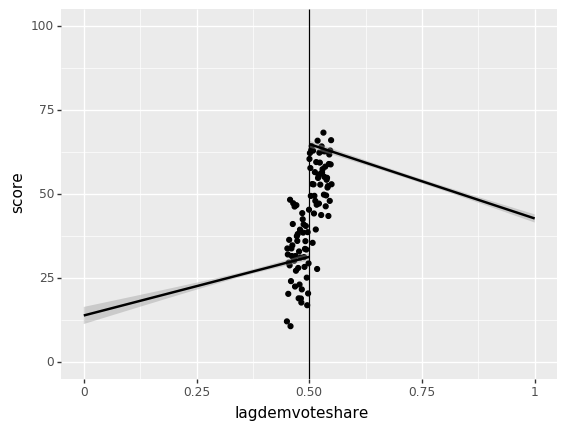

<ggplot: (-9223371908742978664)>

In [92]:
# Linear plot
p.ggplot(lmb_data, p.aes('lagdemvoteshare', 'score')) +    p.geom_point(p.aes(x = 'lagdemvoteshare', y = 'score'), data = agg_lmb_data2) +    p.stat_smooth(p.aes('lagdemvoteshare', 'score', group = 'gg_group'), 
                  data=lmb_data, method = "lm")+\
    p.xlim(0,1) + p.ylim(0,100) +\
    p.geom_vline(xintercept = 0.5)

In [17]:
agg_lmb_data.head()

,lagdemvoteshare_100,score,lagdemvoteshare
0,"(-0.001, 0.01]",18.909834,0.01
1,"(0.01, 0.02]",NaN,0.02
2,"(0.02, 0.03]",NaN,0.03
3,"(0.03, 0.04]",NaN,0.04
4,"(0.04, 0.05]",NaN,0.05


### 2

In [93]:
# Linear Regression within the specified bandwidth
linear_model = smf.ols('score ~ lagdemvoteshare', data=lmb_data2).fit()

# For the quadratic regression, we need to add a squared term of the running variable
lmb_data2['lagdemvoteshare_squared'] = lmb_data2['lagdemvoteshare'] ** 2
quadratic_model = smf.ols('score ~ lagdemvoteshare + lagdemvoteshare_squared', data=lmb_data2).fit()

# Summary of the linear and quadratic models
linear_model_summary = linear_model.summary()
quadratic_model_summary = quadratic_model.summary()

linear_model_summary, quadratic_model_summary


C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                  score   R-squared:                       0.120
 Model:                            OLS   Adj. R-squared:                  0.119
 Method:                 Least Squares   F-statistic:                     331.2
 Date:                Wed, 06 Dec 2023   Prob (F-statistic):           1.68e-69
 Time:                        14:27:02   Log-Likelihood:                -11691.
 No. Observations:                2441   AIC:                         2.339e+04
 Df Residuals:                    2439   BIC:                         2.340e+04
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
 ----------------------------------------------------------------

#### The results show some sensitivity to the shape of the relationship between the outcome and the running variable. The coefficient of lagdemvoteshare is negative in the linear model and positive in the quadratic model, which implies that the relationship is not strongly non-linear within the specified bandwidth. Quadratic specification seems to be more appropriate for the dataset

### 3

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 1322 rows containing missing values.
C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_smooth : Removed 11 rows containing missing values.


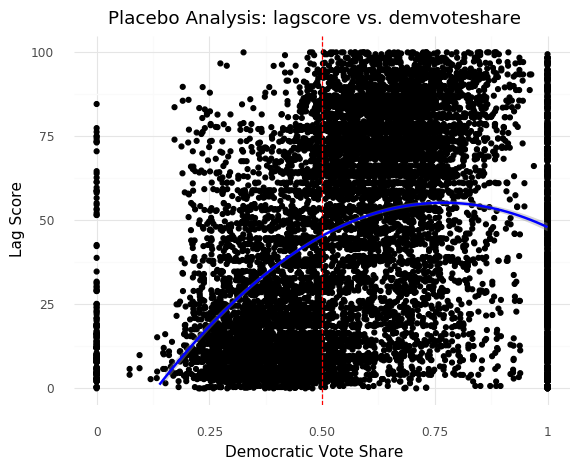

In [86]:
# Graphical analysis
plot3 = (p.ggplot(lmb_data, p.aes(x='demvoteshare', y='lagscore')) +
        p.geom_point() +
        p.stat_smooth(method='lm', formula='y ~ x + I(x**2)', color='blue') +
        p.geom_vline(xintercept=0.5, linetype='dashed', color='red') +
        p.xlim(0,1) + p.ylim(0,100) +\
        p.theme_minimal() +
        p.labs(title='Placebo Analysis: lagscore vs. demvoteshare',
               x='Democratic Vote Share', y='Lag Score'))

print(plot3)

In [68]:
# Create breaks (bins) for demvoteshare
breaks = np.arange(np.floor(lmb_data['demvoteshare'].min()), 
                   np.ceil(lmb_data['demvoteshare'].max()) + 0.01, 
                   step=0.01)

# Create a new column for binning
lmb_data['bin'] = np.searchsorted(breaks, lmb_data['demvoteshare'], side='right')

# Adjust bin numbers to ensure they are within the range of breaks
lmb_data['bin'] = lmb_data['bin'].apply(lambda x: min(x, len(breaks) - 1))

# Group by bin and calculate average lagscore
average_data = lmb_data.groupby('bin').agg(avg_lagscore=pd.NamedAgg(column='lagscore', aggfunc='mean')).reset_index()

# Calculate midpoints for each bin
average_data['midpoint'] = (breaks[average_data['bin'] - 1] + breaks[average_data['bin']]) / 2

# Filter out NaN midpoints
average_data = average_data[~np.isnan(average_data['midpoint'])]

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\stats\smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


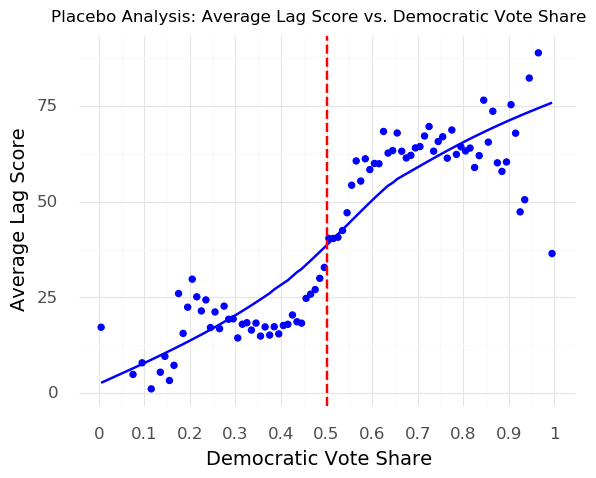

In [79]:
# Plotting
plot4 = (p.ggplot(average_data, p.aes(x='midpoint', y='avg_lagscore')) +
        p.geom_point(size=2, color="blue") +
        p.geom_smooth(method="lowess", color="blue", size=1) +
        p.geom_vline(xintercept=0.5, linetype="dashed", color="red", size=1) +
        p.theme_minimal(base_size=14) +
        p.labs(title="Placebo Analysis: Average Lag Score vs. Democratic Vote Share",
               x="Democratic Vote Share", y="Average Lag Score") +
        p.theme(plot_title=p.element_text(size=12),
                axis_text_x=p.element_text(size=12),
                axis_text_y=p.element_text(size=12),
                legend_title=p.element_text(size=14),
                legend_text=p.element_text(size=12)) +
        p.scale_x_continuous(breaks=np.arange(np.floor(lmb_data['demvoteshare'].min()), 
                                              np.ceil(lmb_data['demvoteshare'].max()) + 0.1, 
                                              step=0.1)) +
        p.scale_y_continuous(limits=(average_data['avg_lagscore'].min(), 
                                     average_data['avg_lagscore'].max())))

print(plot4)


In [56]:
# Linear Regression
linear_model_placebo = smf.ols('lagscore ~ demvoteshare + democrat', data=lmb_data2).fit()

# For the quadratic regression, we need to add a squared term of the running variable
lmb_data2['demvoteshare_squared'] = lmb_data2['demvoteshare'] ** 2
quadratic_model_placebo = smf.ols('lagscore ~ demvoteshare + demvoteshare_squared + democrat', data=lmb_data2).fit()

# Summary of the linear and quadratic models
linear_model_placebo_summary = linear_model_placebo.summary()
quadratic_model_placebo_summary = quadratic_model_placebo.summary()

linear_model_placebo_summary, quadratic_model_placebo_summary

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:               lagscore   R-squared:                       0.052
 Model:                            OLS   Adj. R-squared:                  0.051
 Method:                 Least Squares   F-statistic:                     65.69
 Date:                Wed, 06 Dec 2023   Prob (F-statistic):           1.70e-28
 Time:                        00:52:04   Log-Likelihood:                -11637.
 No. Observations:                2387   AIC:                         2.328e+04
 Df Residuals:                    2384   BIC:                         2.330e+04
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

### 4

In [57]:
from scipy.stats import gaussian_kde

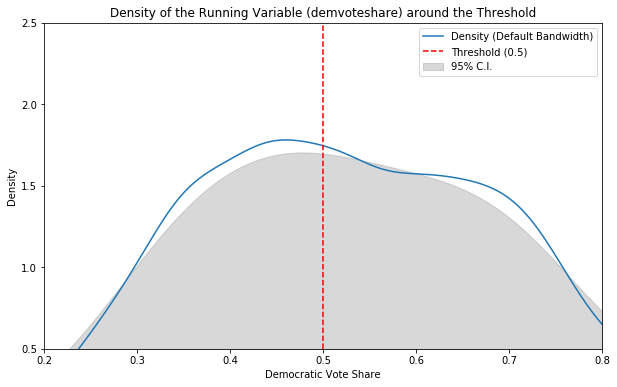

In [66]:
# 'demvoteshare' is the running variable
running_variable = lmb_data['demvoteshare']

# Calculate the density with default bandwidth
density_default = gaussian_kde(running_variable)
x = np.linspace(0.2, 0.8, 1000)  # x-axis range from 0.2 to 0.8
y_default = density_default(x)

# Calculate the density with increased bandwidth for a smoother estimate
factor = 2  # Increase the bandwidth by a factor (can be adjusted)
density_smooth = gaussian_kde(running_variable, bw_method=density_default.factor * factor)
y_smooth = density_smooth(x)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y_default, label='Density (Default Bandwidth)')
plt.fill_between(x, y_smooth, color='gray', alpha=0.3, label='95% C.I.')
plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold (0.5)')
plt.title('Density of the Running Variable (demvoteshare) around the Threshold')
plt.xlabel('Democratic Vote Share')
plt.ylabel('Density')
plt.xlim(0.2, 0.8)  # Set x-axis limits
plt.ylim(0.5, 2.5)  # Set y-axis limits
plt.yticks(np.arange(0.5, 2.6, 0.5))  # y-axis ticks
plt.legend()
plt.show()

In [87]:
from scipy.stats import gaussian_kde

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 62 rows containing missing values.


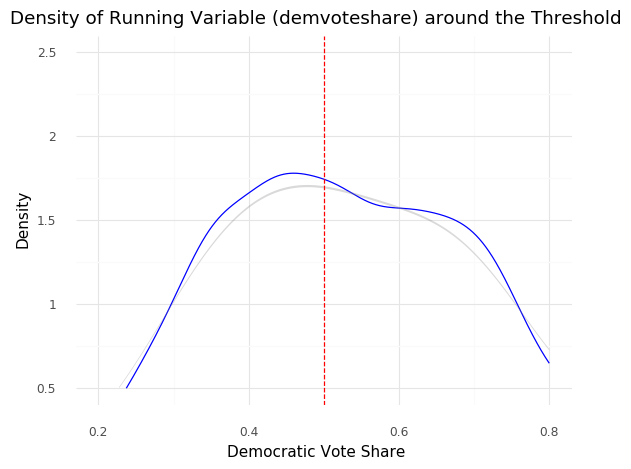

In [94]:
# Assuming 'demvoteshare' is the running variable in lmb_data DataFrame
running_variable = lmb_data['demvoteshare']

# Calculate the density with default bandwidth
density_default = gaussian_kde(running_variable)
x = np.linspace(0.2, 0.8, 1000)
y_default = density_default(x)

# Calculate the density with increased bandwidth for a smoother estimate
factor = 2
density_smooth = gaussian_kde(running_variable, bw_method=density_default.factor * factor)
y_smooth_lower = density_smooth(x) - 1.96 * density_smooth.covariance_factor() * np.sqrt(density_smooth(x)) / np.sqrt(len(running_variable))
y_smooth_upper = density_smooth(x) + 1.96 * density_smooth.covariance_factor() * np.sqrt(density_smooth(x)) / np.sqrt(len(running_variable))

# Create a DataFrame for plotnine
density_df = pd.DataFrame({
    'x': x,
    'y_default': y_default,
    'y_smooth_lower': y_smooth_lower,
    'y_smooth_upper': y_smooth_upper
})

# Plotting with p.ggplot
plot100 = (p.ggplot(density_df, p.aes(x='x')) +
        p.geom_line(p.aes(y='y_default'), color='blue') +
        p.geom_ribbon(p.aes(ymin='y_smooth_lower', ymax='y_smooth_upper'), fill='gray', alpha=0.3) +
        p.geom_vline(xintercept=0.5, color='red', linetype='dashed') +
        p.xlim(0.2, 0.8) +
        p.ylim(0.5, 2.5) +
        p.theme_minimal() +
        p.labs(title='Density of Running Variable (demvoteshare) around the Threshold',
             x='Democratic Vote Share', y='Density'))

print(plot100)
